<a href="https://colab.research.google.com/github/simodepth96/Data-Science-Portfolio/blob/main/Anomaly_Detection_Univariate_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains relevant processes to conduct a **univariate time-series anomaly detection**.

A univariate time series accounts the analysis of individual metrics over time.

> [Anomaly](https://dictionary.cambridge.org/dictionary/english/anomaly) = a person or thing that is different from what is usual, or not in agreement with something else and therefore not satisfactory

In time-series, anomalies can be referred to as **outliers**

> **Outliers** are extreme values sitting 3 standard deviations far distant from the mean.

When a group of anomalies or outliers are identified, they are classed  as a **window**. If the anomalous group move or repurpose over time, they are referred to as *rolling windows*

**Rolling windows** are leveraged by anomaly detection algorithms to capture subset of extreme data points over time.

##Process
Anomaly detection of a univariate time series requires pre-emptive data cleaning and a number of advanced wrangling.

1. Install dependencies (python)
2. Import Univariate time series (XLSX file)
3. Inspect Missing Data
4. Time Series Decomposition - overview and simplify time series analysis
5. Anomaly Detection (Comparing Windows with ADTK - PersistAD)
6. Data Transformation - grouped purchase revenue by date to reduce unwanted data dispersion. Each `date` in the dataset corresponds to the cumulative sum of `purchase revenue` for each sessions available to us for that day (includes all marketing channels)
7. TEST - Purchase Revenue Trend Before Applying Outliers Removal
8. Outliers Removal using IQR rule (variance-based method - fits the bill as it identifies outliers based on how the degree of variation of the outliers to the mean.)
9. Purchase Revenue Trend with Moving Average



In [31]:
!pip install plotly
!pip install adtk
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.stats import zscore

from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import PersistAD
import seaborn as sns

#For converting dates
import datetime
from datetime import datetime

In [32]:
df = pd.read_excel('/content/sitemap_url_non_indicizzabili_nella_sitemap.xlsx', parse_dates=['Date'], sheet_name='data')

# Format the dates as DD/MM/YYYY
df['Date'] = pd.to_datetime(df['Date'])

# Convert 'purchase revenue' to integers for accuracy
df['Purchase revenue'] = df['Purchase revenue'].astype(int).round(2)

#Normalize column names
df.columns = map(str.lower, df.columns)
column_names = df.columns.tolist()

print(len(df))
df.head()

7012


,date,purchase revenue
0,2021-09-21,1638
1,2021-09-21,627
2,2021-09-21,528
3,2021-09-21,8
4,2021-09-21,5


In [33]:
#@title Missing data
'''
Missing Completely at Random (MCAR)= no logical reason why data is missing. Pure chance.

Missing at Random = systematic relationship between missing values and the observed data.
P(A|B) = P(A)* So here missing values exist due to another variable in your dataset.

Missing Not at Random (MNAR): missing data due to a human error.
'''

# counts the number of missing values in each column
df.isna().sum()

,0
date,0
purchase revenue,0


In [34]:
#@title Min and Max points
print(df.describe().loc[['min', 'max']])

                    date  purchase revenue
min  2021-09-21 00:00:00               0.0
max  2024-11-13 00:00:00           52843.0


#Anomaly Detection

Anomaly detection algorithms operate by utilizing rolling windows that capture a subset of data points over time.

These windows serve as a basis for computing various aggregations such as variance, **mean, and median**.

By evaluating the statistical properties of the data within these windows, the algorithms can identify deviations or unexpected patterns.

An approach to measuring anomalies involves **comparing two windows of data**. The following methods benchmark the next value to a window of values that came up before.

1. **LevelshiftAD**: This method detects anomalies based on **significant shifts** in the level of the metric values. It compares the current value with the median or mean of the previous window.
2. **PersistAD**: The PersistAD method identifies persistent anomalies that **persist** across consecutive windows. It evaluates the ratio of the current value to the median or mean of the previous window.
3. **VolatilityShiftAD**: This method detects anomalies based on significant **changes in the variability of the metric values**. It compares the current value’s volatility with that of the previous window.

> Due to the large disparity of residuals, groups of anomalous data points have been detected using the PersistAD model.

/usr/local/lib/python3.10/dist-packages/adtk/detector/_detector_1d.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/usr/local/lib/python3.10/dist-packages/adtk/detector/_detector_1d.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[s.isna()] = np.nan
/usr/local/lib/python3.10/dist-packages/adtk/aggregator/_aggregator.py:211: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  predicted[predicted & lists.isna().any(axis=1)] = 

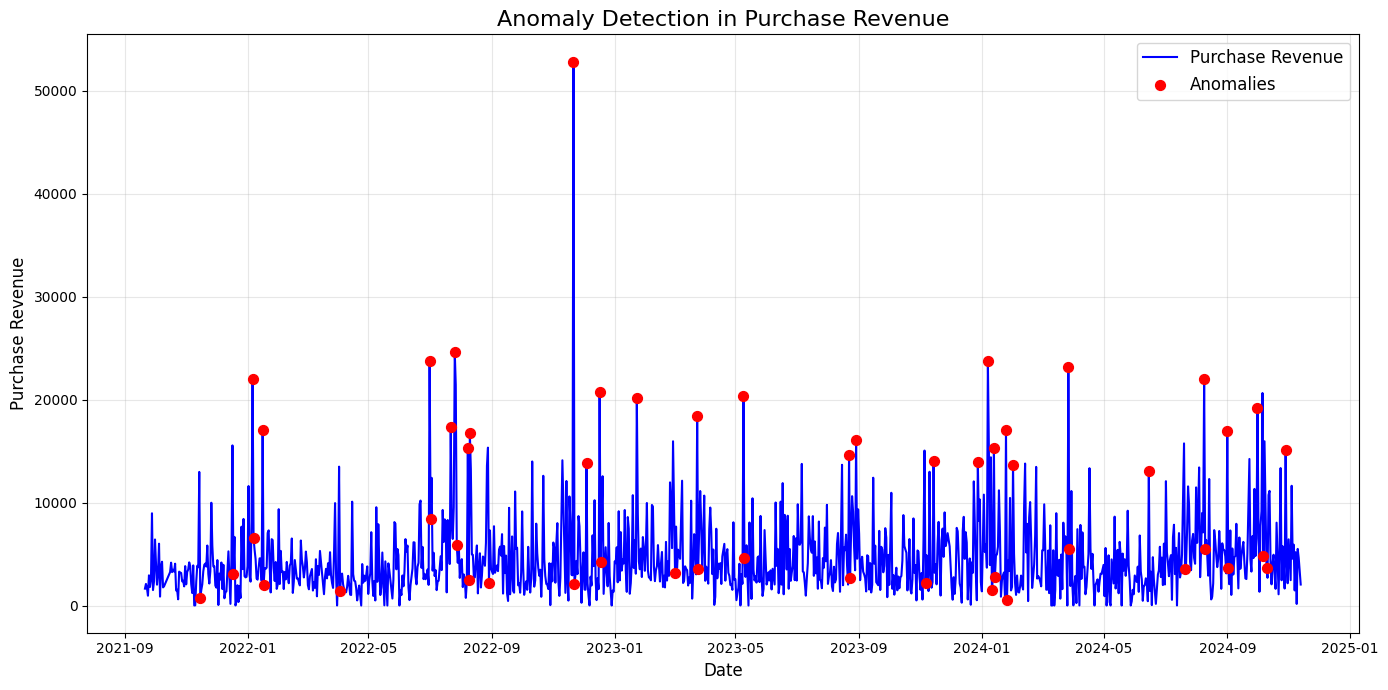

In [39]:
# Ensure 'date' is in datetime format and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Validate the series for anomaly detection
s = validate_series(df['purchase revenue'])

# Use PersistAD to detect anomalies (both negative and positive)
persist_ad = PersistAD(c=2, side='both')
anomalies = persist_ad.fit_detect(s)

# Plot the time series with anomalies using Matplotlib
plt.figure(figsize=(14, 7))

# Plot the baseline (original time series)
plt.plot(s.index, s, label='Purchase Revenue', color='blue', linewidth=1.5)

# Overlay the anomalies on the same plot
anomaly_indices = anomalies[anomalies == True].index
plt.scatter(anomaly_indices, s[anomaly_indices], color='red', label='Anomalies', s=50, zorder=5)

# Add labels, legend, and grid
plt.title('Anomaly Detection in Purchase Revenue', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Purchase Revenue', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()


#Data Transformation

Once mapped out the anomalous point over time, the following script will serve to gradually tackle the tenure of residuals from the time series.

Grouping the sum of cumulative purchase revenue by each date will help us anticipate the outliers removal onlny by applying a pivot table.

In [44]:
pivot = df.pivot_table(
    values='purchase revenue',
    index='date',
    aggfunc='sum'
).sort_index()

grouped_purchase = pivot.reset_index()

#renaming cols
grouped_purchase.columns = ['date', 'purchase revenue']
column_names = grouped_purchase.columns.tolist()

print(len(grouped_purchase))
grouped_purchase.head()

1122


,date,purchase revenue
0,2021-09-21,2808
1,2021-09-22,5851
2,2021-09-23,5026
3,2021-09-24,1857
4,2021-09-25,8351


#Purchase Revenue Trend - Before Outliers Removal (TEST)

In [45]:
#@title Draw a Trendline

# Generate a trendline using linear regression
slope, intercept, r_value, p_value, std_err = linregress(
    pd.to_datetime(grouped_purchase['date']).map(pd.Timestamp.toordinal),
    grouped_purchase['purchase revenue']
)

# Calculate the trendline values
trendline = slope * pd.to_datetime(grouped_purchase['date']).map(pd.Timestamp.toordinal) + intercept

In [49]:
#@title Trend Fatturato Twinset - Pre rimozione Outliers
#grouped_purchase['purchase revenue'] = grouped_purchase['purchase revenue'].rolling(window=8, center=True).mean().fillna(grouped_purchase['purchase revenue'])

fig = go.Figure()

# Add the Smoothed Data line
fig.add_trace(go.Scatter(
    x=grouped_purchase['date'],
    y=grouped_purchase['purchase revenue'],
    mode='lines+markers',
    name='Dati Grezzi',
    line=dict(color='red')
))

# Add the trendline
fig.add_trace(go.Scatter(
    x=grouped_purchase['date'],
    y=trendline,
    mode='lines',
    name='Trend',
    line=dict(color='blue', dash='dash')
))

# Add annotations on the bottom-right side
fig.update_layout(
    title='Trend Fatturato Twinset - Pre rimozione Outliers',
    xaxis_title='Date',
    yaxis_title='Purchase Revenue',
    template='plotly_white',
    width=1400,
    height=500
)

# Show plot
fig.show()


#Outliers Removal

In [54]:
#@title Visualize Outliers
import plotly.express as px

fig = px.violin(grouped_purchase, y='purchase revenue', points="all")
fig.show()

In [51]:
#@title Purchase revenue - 1.5 IQR rule to detect outliers
Q3 = 14484
Q1 = 3829

IQR = grouped_purchase['purchase revenue'].quantile(0.75) - grouped_purchase['purchase revenue'].quantile(0.25)

# Define the lower and upper bounds for outlier detection
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

# Calculate standard deviation
ni_std = grouped_purchase['purchase revenue'].std()
print(f"The std is {ni_std}")

# Detect outliers
ni_outliers = grouped_purchase[(grouped_purchase['purchase revenue'] < lower_bound) | (grouped_purchase['purchase revenue'] > upper_bound)]

# Print the outliers
print(ni_outliers['purchase revenue'])


The std is 9172.511601792216
61      34010
63      31761
102     59701
128     30910
150     37961
271     33149
292     45339
295     37000
296     51962
297     40871
318     36794
328     31193
412     90329
415     30660
418     41296
438     33595
456     39702
474     42292
508     30442
636     50734
683     31214
690     34879
777     37557
817     42980
818     30841
828     34397
829     30613
853     31978
896     40354
998     32107
1010    36362
1021    43747
1026    38456
1041    41590
1071    41127
1074    34441
1075    32576
1077    30511
1079    61817
1086    37958
1112    32627
Name: purchase revenue, dtype: int64


In [52]:
#@title Calculate the Weight of Outliers within the feature

total_values = len(grouped_purchase['purchase revenue'])

percentage_outliers = (len(ni_outliers) / total_values) * 100

print(f"Outliers weight on purchase revenue: {percentage_outliers:.2f}%")

Outliers weight on purchase revenue: 3.65%


In [55]:
#@title Define function to remove outliers

def remove_outlier_IQR(dfWithOutliers):
    Q1=dfWithOutliers.quantile(0.25)
    Q3=dfWithOutliers.quantile(0.75)
    IQR=Q3-Q1
    df_final=dfWithOutliers[~((dfWithOutliers<(Q1-1.5*IQR)) | (dfWithOutliers>(Q3+1.5*IQR)))]
    return df_final

# Removing outliers introduced null values
dfOutliers=grouped_purchase.copy()
dfOutliers=remove_outlier_IQR(grouped_purchase)

In [56]:
#@title Visualize Outliers Removal
#this is what the cleaned dataset look like

fig = px.violin(dfOutliers, y='purchase revenue', points="all")
fig.show()

In [57]:
#@title Sense checking Missing Data
maxRows = dfOutliers['date'].count() #this is the first header in the index

print('% Missing Data:')
print((1 - dfOutliers.count() / maxRows) * 100)

% Missing Data:
date                0.000000
purchase revenue    3.654189
dtype: float64


In [69]:
#@title Listwise deletion
'''
we apply listwise deletion due to data points missing for less than 20% of the dataset
'''
dfOutliers.dropna(inplace=True)
print(f'the number of rows is {dfOutliers.shape[0]}')
print(f'missing data is {dfOutliers.isna().sum().sum()}')

# Convert 'purchase revenue' to integers for accuracy
dfOutliers['purchase revenue'] = dfOutliers['purchase revenue'].astype(int)

#Post anomalies removal
dfOutliers.head()

the number of rows is 1081
missing data is 0


,date,purchase revenue
0,2021-09-21,2808
1,2021-09-22,5851
2,2021-09-23,5026
3,2021-09-24,1857
4,2021-09-25,6761


#Time Series Decomposition

Breaking time series into components (trend, seasonality, residuals) simplifies the overall study providing us with the tenure of errors and indication over potential seasonality.

Time Series Models
1.	**Additive Model**: Suitable for dataset with constant seasonal effects, changes are always constant. Use this model if the seasonal variations are roughly constant in magnitude

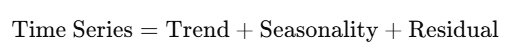
2.	**Multiplicative Model**: For large seasonal variations that grow with the level of the series, and changes over time are visible.

> **Residuals** are the differences between the observed values and the values predicted by the model.

When a model has too many residuals falling too distant from the mean, the model is underfitting meaning it may miss key trends, seasonality, or relationships between variables.


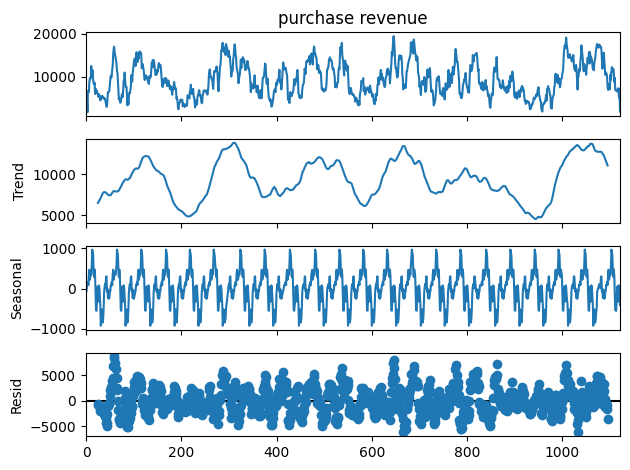

In [79]:
result = seasonal_decompose(dfOutliers['purchase revenue'], model='additive', period=50)
result.plot()
pyplot.show()

##Comment
1. The purchase revenue **trend** looks promising especially with reference to the latest cycles of sale
2. **Seasonality** is visible but is very granular. There appears to be at least **3 cycles of sales** every year (with the **black carat** being the reference)
3. **Residuals** have been limited meaning that the variance of the data points is reduced. Hence, most data points fall close to other centroids.

#Purchase Revenue Trend - Plotting with Moving Average Applied

In [80]:
#@title Draw a Trendline

# Generate a trendline using linear regression
slope, intercept, r_value, p_value, std_err = linregress(
    pd.to_datetime(dfOutliers['date']).map(pd.Timestamp.toordinal),
    dfOutliers['purchase revenue']
)

# Calculate the trendline values
trendline = slope * pd.to_datetime(dfOutliers['date']).map(pd.Timestamp.toordinal) + intercept

In [86]:
#dfOutliers['purchase revenue'] = dfOutliers['purchase revenue'].rolling(window=5, center=True).mean().fillna(dfOutliers['purchase revenue'])

fig = go.Figure()

# Add the Smoothed Data line
fig.add_trace(go.Scatter(
    x=dfOutliers['date'],
    y=dfOutliers['purchase revenue'],
    mode='lines+markers',
    name='Anomalies Free Data',
    line=dict(color='red')
))

# Add the trendline
fig.add_trace(go.Scatter(
    x=dfOutliers['date'],
    y=trendline,
    mode='lines',
    name='Trend',
    line=dict(color='blue', dash='dash')
))

# Add annotations on the bottom-right side
fig.update_layout(
    title='Trend Fatturato Twinset',
    xaxis_title='Date',
    yaxis_title='Purchase Revenue',
    template='plotly_white',
    width=1400,
    height=500,
    annotations=[
        dict(
            xref="paper",
            yref="paper",
            x=1,  # Position at the right side
            y=1,  # Slightly lower than the first annotation
            xanchor="right",
            yanchor="bottom",
            showarrow=False,
            text="* Tutti i canali. Media mobile fatturato cumulato giornaliero. 21/09/2021 - 14/11/2024",
            font=dict(size=10)
        )
    ]
)

# Show plot
fig.show()
